In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
from keras.utils.io_utils import HDF5Matrix

Using TensorFlow backend.


In [2]:
h5_path = 'hernia_chest_xray.h5'
# disease_vec_labels = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion','Emphysema','Fibrosis',
#  'Hernia','Infiltration','Mass','Nodule','Pleural_Thickening','Pneumonia','Pneumothorax']
disease_vec_labels = ['Hernia']
disease_vec = []
with h5py.File(h5_path, 'r') as h5_data:
    all_fields = list(h5_data.keys())
    for c_key in all_fields:
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)
    for c_key in disease_vec_labels:
        disease_vec += [h5_data[c_key][:]]
disease_vec = np.stack(disease_vec,1)
print('Disease Vec:', disease_vec.shape)

Atelectasis (227,) float64
Cardiomegaly (227,) float64
Consolidation (227,) float64
Edema (227,) float64
Effusion (227,) float64
Emphysema (227,) float64
Fibrosis (227,) float64
Finding Labels (227,) |S57
Follow-up # (227,) int64
Height] (227,) int64
Hernia (227,) float64
Image Index (227,) |S16
Infiltration (227,) float64
Mass (227,) float64
Nodule (227,) float64
OriginalImagePixelSpacing[x (227,) float64
OriginalImage[Width (227,) int64
Patient Age (227,) int64
Patient Gender (227,) |S1
Patient ID (227,) int64
Pleural_Thickening (227,) float64
Pneumonia (227,) float64
Pneumothorax (227,) float64
Unnamed: 11 (227,) float64
View Position (227,) |S2
images (227, 128, 128, 1) uint8
path (227,) |S43
y] (227,) float64
Disease Vec: (227, 1)


In [3]:
img_ds = HDF5Matrix(h5_path, 'images', normalizer = lambda x: x/127.5-1)

In [4]:
cat_dim = (4,)
cont_dim = (4,)
noise_dim = (32,)
DS_FACTOR = 4
img_dim = (128//DS_FACTOR, 128//DS_FACTOR, 1)
bn_mode = 0
batch_size = 64
DENSE_VARS = 256

In [5]:
img_ds.shape

(227, 128, 128, 1)

In [ ]:
# img_ds[0][2]

In [6]:
from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda, Reshape
from keras.layers.convolutional import Conv2D, Deconv2D, ZeroPadding2D, UpSampling2D
from keras.layers import Input, merge, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
import keras.backend as K


def generator_upsampling(cat_dim, cont_dim, noise_dim, img_dim, bn_mode, model_name="generator_upsampling", dset="mnist"):
    """
    Generator model of the DCGAN
    args : img_dim (tuple of int) num_chan, height, width
           pretr_weights_file (str) file holding pre trained weights
    returns : model (keras NN) the Neural Net model
    """

    s = img_dim[1]
    f = 128

    if dset == "mnist":
        start_dim = int(s / 4)
        nb_upconv = 2
    else:
        start_dim = int(s / 16)
        nb_upconv = 4

    if K.image_dim_ordering() == "th":
        bn_axis = 1
        reshape_shape = (f, start_dim, start_dim)
        output_channels = img_dim[0]
    else:
        reshape_shape = (start_dim, start_dim, f)
        bn_axis = -1
        output_channels = img_dim[-1]

    cat_input = Input(shape=cat_dim, name="cat_input")
    cont_input = Input(shape=cont_dim, name="cont_input")
    noise_input = Input(shape=noise_dim, name="noise_input")

    gen_input = concatenate([cat_input, cont_input, noise_input])

    x = Dense(DENSE_VARS)(gen_input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Dense(f * start_dim * start_dim)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Reshape(reshape_shape)(x)

    # Upscaling blocks
    for i in range(nb_upconv):
        x = UpSampling2D(size=(2, 2))(x)
        nb_filters = int(f / (2 ** (i + 1)))
        x = Conv2D(nb_filters, (3, 3), padding="same")(x)
        x = BatchNormalization(axis=bn_axis)(x)
        x = Activation("relu")(x)
        # x = Conv2D(nb_filters, (3, 3), padding="same")(x)
        # x = BatchNormalization(axis=bn_axis)(x)
        # x = Activation("relu")(x)

    x = Conv2D(output_channels, (3, 3), name="gen_Conv2D_final", padding="same", activation='tanh')(x)

    generator_model = Model(inputs=[cat_input, cont_input, noise_input], outputs=[x], name=model_name)

    return generator_model


def generator_deconv(cat_dim, cont_dim, noise_dim, img_dim, bn_mode, batch_size, model_name="generator_deconv", dset="mnist"):
    """
    Generator model of the DCGAN
    args : nb_classes (int) number of classes
           img_dim (tuple of int) num_chan, height, width
           pretr_weights_file (str) file holding pre trained weights
    returns : model (keras NN) the Neural Net model
    """

    assert K.backend() == "tensorflow", "Deconv not implemented with theano"

    s = img_dim[1]
    f = 128

    if dset == "mnist":
        start_dim = int(s / 4)
        nb_upconv = 2
    else:
        start_dim = int(s / 16)
        nb_upconv = 4

    reshape_shape = (start_dim, start_dim, f)
    bn_axis = -1
    output_channels = img_dim[-1]

    cat_input = Input(shape=cat_dim, name="cat_input")
    cont_input = Input(shape=cont_dim, name="cont_input")
    noise_input = Input(shape=noise_dim, name="noise_input")

    gen_input = concatenate([cat_input, cont_input, noise_input])

    x = Dense(DENSE_VARS)(gen_input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Dense(f * start_dim * start_dim)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Reshape(reshape_shape)(x)

    # Transposed conv blocks
    for i in range(nb_upconv - 1):
        nb_filters = int(f / (2 ** (i + 1)))
        s = start_dim * (2 ** (i + 1))
        o_shape = (batch_size, s, s, nb_filters)
        x = Deconv2D(nb_filters, (3, 3), output_shape=o_shape, strides=(2, 2), padding="same")(x)
        x = BatchNormalization(axis=bn_axis)(x)
        x = Activation("relu")(x)

    # Last block
    s = start_dim * (2 ** (nb_upconv))
    o_shape = (batch_size, s, s, output_channels)
    x = Deconv2D(output_channels, (3, 3), output_shape=o_shape, strides=(2, 2), padding="same")(x)
    x = Activation("tanh")(x)

    generator_model = Model(inputs=[cat_input, cont_input, noise_input], outputs=[x], name=model_name)

    return generator_model


def DCGAN_discriminator(cat_dim, cont_dim, img_dim, bn_mode, model_name="DCGAN_discriminator", dset="mnist", use_mbd=False):
    """
    Discriminator model of the DCGAN
    args : img_dim (tuple of int) num_chan, height, width
           pretr_weights_file (str) file holding pre trained weights
    returns : model (keras NN) the Neural Net model
    """

    if K.image_dim_ordering() == "th":
        bn_axis = 1
    else:
        bn_axis = -1

    disc_input = Input(shape=img_dim, name="discriminator_input")

    if dset == "mnist":
        list_f = [128]

    else:
        list_f = [64, 128, 256]

    # First conv
    x = Conv2D(64, (3, 3), strides=(2, 2), name="disc_Conv2D_1", padding="same")(disc_input)
    x = LeakyReLU(0.2)(x)

    # Next convs
    for i, f in enumerate(list_f):
        name = "disc_Conv2D_%s" % (i + 2)
        x = Conv2D(f, (3, 3), strides=(2, 2), name=name, padding="same")(x)
        x = BatchNormalization(axis=bn_axis)(x)
        x = LeakyReLU(0.2)(x)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    def linmax(x):
        return K.maximum(x, -16)

    def linmax_shape(input_shape):
        return input_shape

    # More processing for auxiliary Q
    x_Q = Dense(128)(x)
    x_Q = BatchNormalization()(x_Q)
    x_Q = LeakyReLU(0.2)(x_Q)
    x_Q_Y = Dense(cat_dim[0], activation='softmax', name="Q_cat_out")(x_Q)
    x_Q_C_mean = Dense(cont_dim[0], activation='linear', name="dense_Q_cont_mean")(x_Q)
    x_Q_C_logstd = Dense(cont_dim[0], name="dense_Q_cont_logstd")(x_Q)
    x_Q_C_logstd = Lambda(linmax, output_shape=linmax_shape)(x_Q_C_logstd)
    # Reshape Q to nbatch, 1, cont_dim[0]
    x_Q_C_mean = Reshape((1, cont_dim[0]))(x_Q_C_mean)
    x_Q_C_logstd = Reshape((1, cont_dim[0]))(x_Q_C_logstd)
    x_Q_C = concatenate([x_Q_C_mean, x_Q_C_logstd], name="Q_cont_out", axis=1)

    def minb_disc(z):
        diffs = K.expand_dims(z, 3) - K.expand_dims(K.permute_dimensions(z, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), 2)
        z = K.sum(K.exp(-abs_diffs), 2)

        return z

    def lambda_output(input_shape):
        return input_shape[:2]

    num_kernels = 300
    dim_per_kernel = 5

    M = Dense(num_kernels * dim_per_kernel, use_bias=False, activation=None)
    MBD = Lambda(minb_disc, output_shape=lambda_output)

    if use_mbd:
        x_mbd = M(x)
        x_mbd = Reshape((num_kernels, dim_per_kernel))(x_mbd)
        x_mbd = MBD(x_mbd)
        x = merge([x, x_mbd], mode='concat')

    # Create discriminator model
    x_disc = Dense(2, activation='softmax', name="disc_out")(x)
    discriminator_model = Model(inputs=[disc_input], outputs=[x_disc, x_Q_Y, x_Q_C], name=model_name)

    return discriminator_model


def DCGAN(generator, discriminator_model, cat_dim, cont_dim, noise_dim):

    cat_input = Input(shape=cat_dim, name="cat_input")
    cont_input = Input(shape=cont_dim, name="cont_input")
    noise_input = Input(shape=noise_dim, name="noise_input")

    generated_image = generator([cat_input, cont_input, noise_input])
    x_disc, x_Q_Y, x_Q_C = discriminator_model(generated_image)

    DCGAN = Model(inputs=[cat_input, cont_input, noise_input],
                  outputs=[x_disc, x_Q_Y, x_Q_C],
                  name="DCGAN")

    return DCGAN


def create_model(model_name, cat_dim, cont_dim, noise_dim, img_dim, 
                 bn_mode, batch_size, dset="mnist", use_mbd=False):

    if model_name == "generator_upsampling":
        model = generator_upsampling(cat_dim, cont_dim, noise_dim, img_dim, bn_mode, model_name=model_name, dset=dset)
        model.summary()
        try:
            from keras.utils import plot_model
            plot_model(model, to_file='%s.png' % model_name, show_shapes=True, show_layer_names=True)
        except:
            print('No Plot!')
        return model
    if model_name == "generator_deconv":
        model = generator_deconv(cat_dim, cont_dim, noise_dim, img_dim, bn_mode,
                                 batch_size, model_name=model_name, dset=dset)
        model.summary()
        try:
            from keras.utils import plot_model
            plot_model(model, to_file='%s.png' % model_name, show_shapes=True, show_layer_names=True)
        except:
            print('No Plot!')
        return model
    if model_name == "DCGAN_discriminator":
        model = DCGAN_discriminator(cat_dim, cont_dim, img_dim, bn_mode,
                                    model_name=model_name, dset=dset, use_mbd=use_mbd)
        model.summary()
        try:
            from keras.utils import plot_model
            plot_model(model, to_file='%s.png' % model_name, show_shapes=True, show_layer_names=True)
        except:
            print('No Plot!')
        return model

In [7]:
generator_model = create_model("generator_deconv",
                              cat_dim,
                              cont_dim,
                              noise_dim,
                              img_dim,
                              bn_mode,
                              batch_size)
# Load discriminator model
discriminator_model = create_model("DCGAN_discriminator",
                                  cat_dim,
                                  cont_dim,
                                  noise_dim,
                                  img_dim,
                                  bn_mode,
                                  batch_size)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:118: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")`
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:125: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(1, (3, 3), strides=(2, 2), padding="same")`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat_input (InputLayer)          (None, 4)            0                                            
__________________________________________________________________________________________________
cont_input (InputLayer)         (None, 4)            0                                            
__________________________________________________________________________________________________
noise_input (InputLayer)        (None, 32)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 40)           0           cat_input[0][0]                  
                                                                 cont_input[0][0]                 
          

In [8]:
import keras.backend as K
def gaussian_loss(y_true, y_pred):

    Q_C_mean = y_pred[:, 0, :]
    Q_C_logstd = y_pred[:, 1, :]

    y_true = y_true[:, 0, :]

    epsilon = (y_true - Q_C_mean) / (K.exp(Q_C_logstd) + K.epsilon())
    loss_Q_C = (Q_C_logstd + 0.5 * K.square(epsilon))
    loss_Q_C = K.mean(loss_Q_C)

    return loss_Q_C

In [9]:
from keras.optimizers import Adam
opt_dcgan = Adam(lr=1E-4, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
opt_discriminator = Adam(lr=1E-4, beta_1=0.5, beta_2=0.999, epsilon=1e-08)

In [10]:
generator_model.compile(loss='mse', optimizer=opt_discriminator)
discriminator_model.trainable = False
DCGAN_model = DCGAN(generator_model,
                   discriminator_model,
                   cat_dim,
                   cont_dim,
                   noise_dim)

In [11]:
list_losses = ['binary_crossentropy', 'categorical_crossentropy', gaussian_loss]
list_weights = [1, 1, 1]
DCGAN_model.compile(loss=list_losses, loss_weights=list_weights, optimizer=opt_dcgan)

In [12]:
# Multiple discriminator losses
discriminator_model.trainable = True
discriminator_model.compile(loss=list_losses, loss_weights=list_weights, optimizer=opt_discriminator)

gen_loss = 100
disc_loss = 100

In [13]:
def sample_noise(noise_scale, batch_size, noise_dim):
    return np.random.normal(scale=noise_scale, size=(batch_size, noise_dim[0]))

def sample_cat(batch_size, cat_dim):
    y = np.zeros((batch_size, cat_dim[0]), dtype="float32")
    random_y = np.random.randint(0, cat_dim[0], size=batch_size)
    y[np.arange(batch_size), random_y] = 1
    return y

def get_disc_batch(X_real_batch, generator_model, batch_counter, batch_size, cat_dim, cont_dim, noise_dim,
                   noise_scale=0.5, label_smoothing=False, label_flipping=0):

    # Create X_disc: alternatively only generated or real images
    if batch_counter % 2 == 0:
        # Pass noise to the generator
        y_cat = sample_cat(batch_size, cat_dim)
        y_cont = sample_noise(noise_scale, batch_size, cont_dim)
        noise_input = sample_noise(noise_scale, batch_size, noise_dim)
        # Produce an output
        X_disc = generator_model.predict([y_cat, y_cont, noise_input],batch_size=batch_size)
        y_disc = np.zeros((X_disc.shape[0], 2), dtype=np.uint8)
        y_disc[:, 0] = 1

        if label_flipping > 0:
            p = np.random.binomial(1, label_flipping)
            if p > 0:
                y_disc[:, [0, 1]] = y_disc[:, [1, 0]]

    else:
        X_disc = X_real_batch
        y_disc = np.zeros((X_disc.shape[0], 2), dtype=np.uint8)
        y_cat = sample_cat(batch_size, cat_dim)
        y_cont = sample_noise(noise_scale, batch_size, cont_dim)
        if label_smoothing:
            y_disc[:, 1] = np.random.uniform(low=0.9, high=1, size=y_disc.shape[0])
        else:
            y_disc[:, 1] = 1

        if label_flipping > 0:
            p = np.random.binomial(1, label_flipping)
            if p > 0:
                y_disc[:, [0, 1]] = y_disc[:, [1, 0]]

    # Repeat y_cont to accomodate for keras" loss function conventions
    y_cont = np.expand_dims(y_cont, 1)
    y_cont = np.repeat(y_cont, 2, axis=1)

    return X_disc, y_disc, y_cat, y_cont

def get_gen_batch(batch_size, cat_dim, cont_dim, noise_dim, noise_scale=0.5):
    X_gen = sample_noise(noise_scale, batch_size, noise_dim)
    y_gen = np.zeros((X_gen.shape[0], 2), dtype=np.uint8)
    y_gen[:, 1] = 1

    y_cat = sample_cat(batch_size, cat_dim)
    y_cont = sample_noise(noise_scale, batch_size, cont_dim)

    # Repeat y_cont to accomodate for keras" loss function conventions
    y_cont_target = np.expand_dims(y_cont, 1)
    y_cont_target = np.repeat(y_cont_target, 2, axis=1)

    return X_gen, y_gen, y_cat, y_cont, y_cont_target

def normalization(X):
    return X / 127.5 - 1

def inverse_normalization(X):
    return (X + 1.) / 2.

def plot_generated_batch(X_real, generator_model, batch_size, cat_dim, cont_dim, noise_dim, 
                         image_data_format = "channels_last", 
                         noise_scale=0.5,
                        epoch = 0):

    plt.close('all')
    # Generate images
    y_cat = sample_cat(batch_size, cat_dim)
    y_cont = sample_noise(noise_scale, batch_size, cont_dim)
    noise_input = sample_noise(noise_scale, batch_size, noise_dim)
    # Produce an output
    X_gen = generator_model.predict([y_cat, y_cont, noise_input],batch_size=batch_size)

    X_real = inverse_normalization(X_real)
    X_gen = inverse_normalization(X_gen)

    Xg = X_gen[:8]
    Xr = X_real[:8]

    if image_data_format == "channels_last":
        X = np.concatenate((Xg, Xr), axis=0)
        list_rows = []
        for i in range(int(X.shape[0] / 4)):
            Xr = np.concatenate([X[k] for k in range(4 * i, 4 * (i + 1))], axis=1)
            list_rows.append(Xr)

        Xr = np.concatenate(list_rows, axis=0)

    if image_data_format == "channels_first":
        X = np.concatenate((Xg, Xr), axis=0)
        list_rows = []
        for i in range(int(X.shape[0] / 4)):
            Xr = np.concatenate([X[k] for k in range(4 * i, 4 * (i + 1))], axis=2)
            list_rows.append(Xr)

        Xr = np.concatenate(list_rows, axis=1)
        Xr = Xr.transpose(1,2,0)

    if Xr.shape[-1] == 1:
        plt.imshow(Xr[:, :, 0], cmap="gray")
    else:
        plt.imshow(Xr)
    plt.savefig("%04d_batch.png" % epoch)
    

In [14]:
# Start training
from keras.utils import generic_utils
import time
nb_epoch = 1
epoch_size = img_ds.shape[0]
n_batch_per_epoch = epoch_size//batch_size

noise_scale=0.5
label_smoothing=False
label_flipping=0
print("Start training")
def train_func(e):
    # Initialize progbar and batch counter
    progbar = generic_utils.Progbar(epoch_size)
    batch_counter = 1
    start = time.time()
    # randomly pick out regions in the image
    for r_idx in np.random.choice(range(img_ds.shape[0]-batch_size), size = n_batch_per_epoch):
        X_real_batch = img_ds[r_idx:(r_idx+batch_size)][:, ::DS_FACTOR, ::DS_FACTOR]
        # Create a batch to feed the discriminator model
        X_disc, y_disc, y_cat, y_cont = get_disc_batch(X_real_batch,
                                                      generator_model,
                                                      batch_counter,
                                                      batch_size,
                                                      cat_dim,
                                                      cont_dim,
                                                      noise_dim,
                                                      noise_scale=noise_scale,
                                                      label_smoothing=label_smoothing,
                                                      label_flipping=label_flipping)

        # Update the discriminator
        disc_loss = discriminator_model.train_on_batch(X_disc, [y_disc, y_cat, y_cont])

        # Create a batch to feed the generator model
        X_gen, y_gen, y_cat, y_cont, y_cont_target = get_gen_batch(batch_size,
                                                                      cat_dim,
                                                                      cont_dim,
                                                                      noise_dim,
                                                                      noise_scale=noise_scale)

        # Freeze the discriminator
        discriminator_model.trainable = False
        gen_loss = DCGAN_model.train_on_batch([y_cat, y_cont, X_gen], [y_gen, y_cat, y_cont_target])
        # Unfreeze the discriminator
        discriminator_model.trainable = True

        batch_counter += 1
        progbar.add(batch_size, values=[("D tot", disc_loss[0]),
                                        ("D log", disc_loss[1]),
                                        ("D cat", disc_loss[2]),
                                        ("D cont", disc_loss[3]),
                                        ("G tot", gen_loss[0]),
                                        ("G log", gen_loss[1]),
                                        ("G cat", gen_loss[2]),
                                        ("G cont", gen_loss[3])])

        # Save images for visualization
        if batch_counter % (n_batch_per_epoch // 3) == 0:
            plot_generated_batch(X_real_batch, generator_model,
                                            batch_size, cat_dim, cont_dim, noise_dim, epoch = e)

        if batch_counter >= n_batch_per_epoch:
            break

    print("")
    print('Epoch %s/%s, Time: %s' % (e + 1, nb_epoch, time.time() - start))    

Start training


Instructions for updating:
Use tf.cast instead.
128/227 [===============>..............] - ETA: 6s - D tot: 39.8963 - D log: 0.9785 - D cat: 1.7924 - D cont: 37.1255 - G tot: 8.2261 - G log: 1.4952 - G cat: 1.8043 - G cont: 4.9265 
Epoch 1/1, Time: 8.901780128479004
128/227 [===============>..............] - ETA: 1s - D tot: 22.1699 - D log: 0.9647 - D cat: 1.7144 - D cont: 19.4908 - G tot: 9.1218 - G log: 1.4642 - G cat: 1.7864 - G cont: 5.8713 
Epoch 2/1, Time: 1.468409776687622
128/227 [===============>..............] - ETA: 0s - D tot: 15.6328 - D log: 0.9621 - D cat: 1.6452 - D cont: 13.0256 - G tot: 9.2579 - G log: 1.4412 - G cat: 1.7612 - G cont: 6.0554
Epoch 3/1, Time: 1.372788906097412
128/227 [===============>..............] - ETA: 1s - D tot: 8.8189 - D log: 0.9448 - D cat: 1.8010 - D cont: 6.0731 - G tot: 7.4391 - G log: 1.4279 - G cat: 1.7290 - G cont: 4.2823
Epoch 4/1, Time: 1.7810258865356445
128/227 [===============>..............] - ETA: 0s - D tot: 10.2005 - D log: 0.

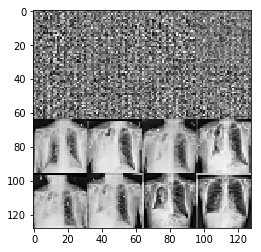

In [15]:
for e in range(10):
    train_func(e)

In [ ]:
out_batch_size = 1024
y_cat = sample_cat(out_batch_size, cat_dim)
y_cont = sample_noise(noise_scale, out_batch_size, cont_dim)
noise_input = sample_noise(noise_scale, out_batch_size, noise_dim)
X_gen = generator_model.predict([y_cat, y_cont, noise_input], batch_size=batch_size, verbose = True)

In [ ]:
from skimage.util import montage as montage
fig, ax1 = plt.subplots(1,1, figsize = (12, 12))
ax1.imshow(montage(X_gen[:,:,:,0]))
fig.savefig('generated_chestxrays.png', dpi = 300)

In [ ]:
# generator_model.save('gen_model.h5')
# discriminator_model.save('disc_model.h5')

In [ ]:
from keras.models import load_model
del generator_model
del discriminator_model
import gc
gc.collect()

In [ ]:
generator_model = load_model('gen_model.h5', custom_objects={'gaussian_loss': gaussian_loss})
discriminator_model = load_model('disc_model.h5', custom_objects={'gaussian_loss': gaussian_loss})

In [ ]:
X_gen = generator_model.predict([y_cat, y_cont, noise_input], batch_size=batch_size, verbose = True)

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (12, 12))
ax1.imshow(montage(X_gen[:,:,:,0]))
fig.savefig('generated_chestxrays.png', dpi = 300)

In [ ]:
X_gen[0][0][0]

In [ ]:
y_gen = discriminator_model.predict(X_gen, batch_size=batch_size, verbose = True)

In [ ]:
y_gen[:10][0]

In [ ]:
# from PIL import Image
image = X_gen[0]
fig, ax1 = plt.subplots()
ax1.imshow(montage(X_gen[:1,:,:,0]))
fig.savefig('sample.png', dpi = 300)
# print(image)
# Image.fromarray(image.astype(np.uint8)).save("sample1.png")